In [1]:
import numpy as np
from pysr import PySRRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)
from sympy import pretty

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
def r2_calc(y, y_pred):
    r2 =r2_score(y, y_pred)
    print("R2 score: ", r2)
    return r2, y, y_pred

def mse_calc(y, y_pred):
    mse = mean_squared_error(y, y_pred)
    print("Mean Squared Error: ", mse)
    return mse

def error_percentage(y, y_pred):
    error = np.mean(np.abs((y - y_pred) / y)) * 100
    print("Mean Absolute Percentage Error: ", error)
    return error

# detect outliers using 3 standard deviation
def detect_outliers(data, threshold=3):
    mean = np.mean(data['delta_phi'])
    std_dev = np.std(data['delta_phi'])
    outliers = []
    for i in data['delta_phi']:
        z_score = (i - mean) / std_dev
        if np.abs(z_score) > threshold:
            outliers.append(i)
    data_without_outliers = data[~data['delta_phi'].isin(outliers)]
    return data_without_outliers


In [3]:
argon = pd.read_csv('data/real_ufrac_argon.csv')
water = pd.read_csv('data/real_ufrac_water.csv')
methane = pd.read_csv('data/real_ufrac_methane.csv')

In [20]:
water_without_outliers = detect_outliers(water)
len_water = len(water)
len_water_without_outliers = len(water_without_outliers)
print("Number of outliers in water data: ", len_water - len_water_without_outliers)

Number of outliers in water data:  3


In [21]:
substance = 'water'
data_p = water_without_outliers
model = PySRRegressor.from_file(f'result/uv_trial_{substance}_8.pkl')
#model = PySRRegressor.from_file('hall_of_fame_2024-10-08_060720.830.pkl')

Checking if result/uv_trial_water_8.pkl exists...
Loading model from result/uv_trial_water_8.pkl


In [22]:
X = data_p.iloc[:, 1:3]
y = data_p['delta_phi']
y_pred = model.predict(X)
r2 = r2_calc(y, y_pred)
mse = mse_calc(y, y_pred)
mape = error_percentage(y, y_pred)


R2 score:  0.9443710327958624
Mean Squared Error:  0.02338205309700101
Mean Absolute Percentage Error:  73.13937078431483


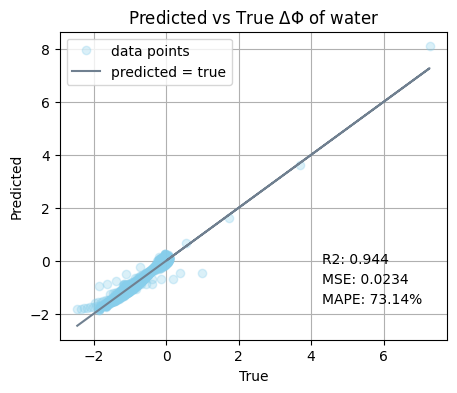

In [23]:
fig = plt.figure(figsize=(5,4))
plt.plot(y, y_pred, 'o',label='data points',color='skyblue', alpha=0.3)
plt.plot(y, y, 'slategrey', label='predicted = true')
plt.text(0.65, 0.3, f'R2: {r2_score(y, y_pred):.3f}', transform=fig.transFigure)
plt.text(0.65, 0.25, f'MSE: {mean_squared_error(y, y_pred):.4f}', transform=fig.transFigure)
plt.text(0.65, 0.20, f'MAPE: {np.mean(np.abs((y - y_pred) / y)) * 100:.2f}%', transform=fig.transFigure)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.legend()
#plt.ylim(-2,2)
#plt.xlim(-2,2)
plt.title(f"Predicted vs True $\\Delta \\Phi$ of {substance}")
plt.grid()
plt.show()

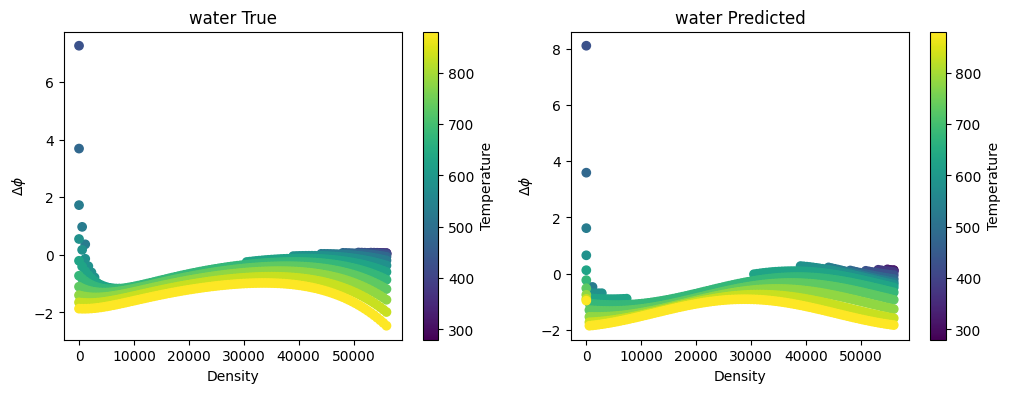

In [24]:
fig = plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
scatter = plt.scatter(data_p['density'], data_p['delta_phi'], c=data_p['temperature'], cmap='viridis')
color_bar = plt.colorbar(scatter)
color_bar.set_label('Temperature')
plt.xlabel('Density')
#plt.ylim(-2,2)
plt.ylabel('$\\Delta \\phi$')
# plot phi = -0.4
#plt.axhline(y=-0.27, color='r', linestyle='--')
#plt.axhline(y=0, color='r', linestyle='--')
plt.title(f'{substance} True')
plt.subplot(1,2,2)
scatter = plt.scatter(data_p['density'], y_pred, c=data_p['temperature'], cmap='viridis')
color_bar = plt.colorbar(scatter)
color_bar.set_label('Temperature')
plt.xlabel('Density')
plt.ylabel('$\\Delta \\phi$')
plt.title(f'{substance} Predicted')
#plt.ylim(-2,2)
#plt.axhline(y=-0.45, color='r', linestyle='--')
#plt.axhline(y=0, color='r', linestyle='--')
plt.show()

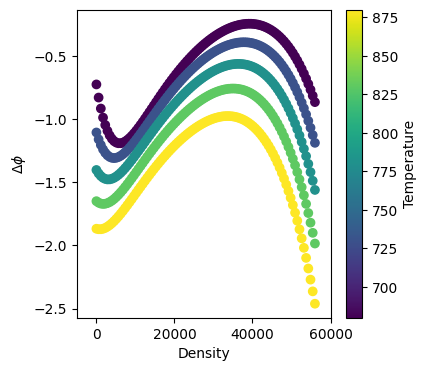

In [25]:
data_pl = water[(water['temperature']>=680) & (water['temperature']<=880)]
fig = plt.figure(figsize=(9, 4))
plt.subplot(1,2,1)
scatter = plt.scatter(data_pl['density'], data_pl['delta_phi'], c=data_pl['temperature'], cmap='viridis')
color_bar = plt.colorbar(scatter)
color_bar.set_label('Temperature')
plt.xlabel('Density')
plt.xlim(-5000,60000)
#plt.ylim(-3, 7)
plt.ylabel('$\\Delta \\phi$')
plt.show()

In [26]:
best_model = model.get_best()
print(best_model)


complexity                                                                                                                                               19
loss                                                                                                                                               0.018787
score                                                                                                                                              0.195422
equation                          tan(0.7892731 * (inv(density) - cos(temperature))) - square(cos(-0.25552627 * (density + cos(temperature * -0.8917469))))
sympy_format                      -cos(0.25552627*density + 0.25552627*cos(0.8917469*temperature))**2 - tan(0.7892731*cos(temperature) - 0.7892731/density)
lambda_format    PySRFunction(X=>-cos(0.25552627*density + 0.25552627*cos(0.8917469*temperature))**2 - tan(0.7892731*cos(temperature) - 0.7892731/density))
Name: 15, dtype: object
